## 생성 모델링 이미지 생성기

### 학습 목표
- 생성 모델링 개념을 이해하며 판별 모델링과의 차이 알기
- Pix2Pix, CycleGAN 등의 이미지 관련 다양한 생성 모델링의 응용을 접하며 흥미 가지기
- Fashion MNIST 데이터셋의 의미를 알기
- 생성적 적대 신경망(GAN)의 구조와 원리를 이해하기
- 텐서플로우로 짠 DCGAN 학습 코드를 익히며 응용하기

### 루브릭 
-  GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다. : **오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.**
- 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다. : **gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.**
- 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다. : **제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다.**

## 목차
### 1. 데이터 준비
### 2. 생성자(Generator) 만들기
### 3. 판별자(Discriminator) 만들기
### 4. 모델 학습 및 결과물 확인
---

## 1. 데이터 준비

In [1]:
import os
import glob
import time
import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 3s 0us/step


(50000, 32, 32, 3)

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [4]:
# 픽셀 정규화
train_x = (train_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

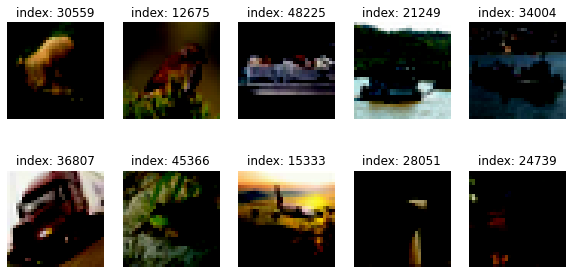

In [5]:
plt.figure(figsize=(10,5))

for i in range(10):
    a = np.random.randint(49999)
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[a])
    plt.title(f'index: {a}')
    plt.axis('off')
plt.show()

In [6]:
BUFFER_SIZE = 50000
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

* from_tensor_slices(): 리스트, 넘파이, 텐서플로우의 텐서 자료형에서 데이터셋을 만드는 명령어.
  * shuffle(BUFFER_SIZE): buffer size만큼의 데이터를 섞는다.
  * batch(BATCH_SIZE): 모델이 한 번에 학습할 데이터의 양(batch size)으로 나눈다.

In [7]:
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

cifar10의 train data를 tensorflow 배치 데이터셋으로 가공한다.

## 2. 생성자 만들기

In [8]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer: input (batch_size, 100) 벡터 -> output (batch_size, 8*8*256) 벡터
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [9]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [10]:
noise = tf.random.normal([1,100])

In [11]:
generated_image = generator(noise,training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

100차원의 input 벡터를 받아 (32,32,3) 이미지로 만드는 generator를 생성한다. (TensorShape는 (batch size, height, width, channel))

## 3. 판별자 만들기

In [12]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [13]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)        

In [14]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00242267]], dtype=float32)>

generator와 반대로 (32,32,3) 이미지를 입력받으면 1차원의 숫자를 반환하는 discriminator를 생성한다.

## 4. 모델 학습 및 결과물 확인

In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [16]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [17]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

* fake_output: generator가 만들어낸 이미지를 discriminator가 판별한 값 
* real_output: 데이터셋에 있던 진짜 이미지를 discriminator가 판별한 값

generator의 손실함수는 fake_output이 1(참)에 가까워지게끔 하도록 cross entropy(1, fake_output)의 형태로 정의된다.

disciminator는 real_output은 1(참)에, fake_output은 0(거짓)에 가까워지게끔 해야 하는(즉, 진짜를 진짜로 판별하고, 가짜를 가짜로 판별하는) 두가지 구분을 시행해야 하므로 cross entropy(1, real_output)와 cross entropy (0, fake_output)의 합으로 손실함수를 정의한다.

In [18]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

* tf.math.greater_equal(real_output, tf.constant([0.5]) : discriminator의 real_output은 1에 가까워져야 하므로, real_output의 각 원소가 0.5 이상이면 True, 0.5 미만이면 False로 판별. 
* tf.math.greater_equal(fake_output, tf.constant([0.5]) : discrimonator의 fake_output은 0에 가까워져야 하므로, fake_output의 각 원소가 0.5 미만이면 True, 0.5 이상이면 False로 판별. 
* tf.cast((1), tf.float32) : (1)이 True이면 1.0, False이면 0.0으로 변환
* tf.reduce_mean((2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.SGD(3e-4)

[How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)의 권장사항에 따라 각 모델의 최적화함수로 generator는 Adam, discriminator는 SGD를 사용한다. 

학습률은 [10 Lessons I Learned Training GANs for one Year](https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628)에 따라 가능한 작은 값으로 설정하되 discriminator에는 더 높은 학습률을 적용하여, generator에 0.00001, discriminator에 0.0003로 설정한다.

In [20]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [21]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈(128, 100)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [22]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples_2/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [23]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)   
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss']) 
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'],'.')
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history_2/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [24]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints_2'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [25]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [26]:
save_every = 10
EPOCHS = 400

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

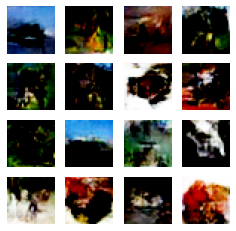

Time for training : 8661 sec


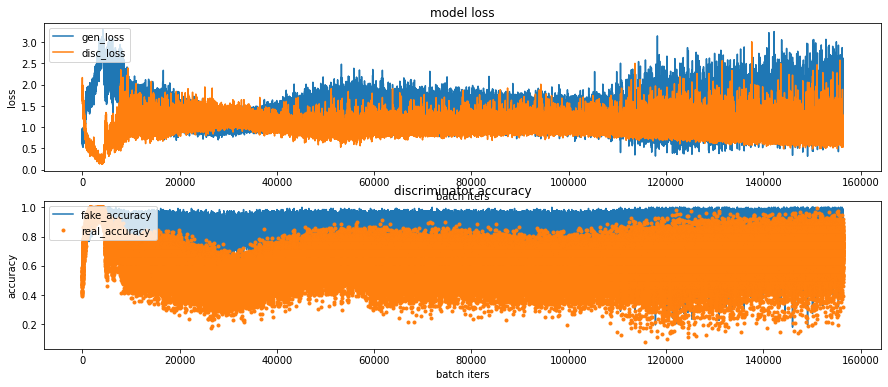

CPU times: user 2h 32min 52s, sys: 17min 2s, total: 2h 49min 54s
Wall time: 2h 24min 30s


In [27]:
%%time
train(train_dataset, EPOCHS, save_every)

In [28]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_2.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples_2/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_2.gif

-rw-r--r-- 1 root root 3488499 Feb 15 14:53 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_2.gif


## 회고

- 노드에 소개된 [GAN trainning tips and tricks](https://github.com/soumith/ganhacks) 등에 의하면, discriminator는 SGD 최적화 함수를 사용하고 학습률도 높여주는 것을 권하고 있는데 반해, generator에 권장되는 Adam은 SGD에서 발생하는 오버슈팅 등의 단점을 보완한 알고리즘이고 학습률 역시 작게 설정하는 것이 바람직하다는 것은 **discriminator에 비해 generator가 '더 세심하게' 최적해를 찾는 모델이 되어야 한다는 의미인 듯 하다.** 위조지폐범과 경찰의 비유를 쓰면, 사용자의 목표는 진짜와 구분 가지 않는 '위조지폐'를 만드는 것이니 위조지폐범 generator의 성능이 더 높아야 한다는 뜻으로 받아들일 수 있을 것 같다. 이유를 두가지 갈래로 추측해보았다.
  * 어떤 이미지가 진짜인지 가짜인지 구분하는 discriminator의 과제보다, 만들 수 있는 이미지의 무수히 많은 경우의 수 중에서 진짜인지 구분할 수 없는 이미지를 만들어야 하는 generator의 과제가 더 어렵기 때문에 generator를 더 섬세한 모델로 만들어야 한다.
  * 학습률이 높으면 최적해를 벗어나는 위험성도 있지만 빠르게 해를 찾을 수 있다. generator는 discriminator가 판별한 결과를 손실함수로 삼아 학습을 진행하기 때문에, discriminator가 동작하는 속도는 generator보다 빨라야 한다. 
* 단, 학습률을 계속 낮춘다고 해서 모델의 성능이 계속해서 좋아지는 것은 아닐 것이다. 적절한 학습률은 모델의 최적해를 찾는 경로와 관계가 있을텐데, 모델의 최적해 경로는 배치 사이즈에 따라서 '거칠어지거나' '매끄러워'질 것이다. 배치 사이즈와 학습률의 적절한 비중을 찾고, discriminator와 generator 사이의 균형을 맞추는 것이 GAN 모델의 관건이 아닐까 추측해본다. 
- discriminator의 참,거짓 구분에 label smoothing을 적용하여, 참은 1, 거짓은 0이 아니라 약간의 범위 값으로 설정하는 것이 권장되기도 하는데, 그렇다면 손실함수를 이진 크로스엔트로피 대신 어떻게 변형할 수 있을지 궁금하다.
- epoch을 크게 했을 경우 더 실제와 가까워지는 게 아니라 오히려 물체 형상이 어그러지는 경우가 있다. 보통 epoch이 너무 크면 모델에 과적합 문제가 발생한다고 하는데, 서로 다른 두 모델 generator와 discriminator가 'fake_output' 값을 통해 손실함수를 정의, 서로의 '피드백'이 되는 셈인 이 모델에서 과적합이 발생한다면 어떤 상황이라고 이해하면 좋을까. 위조지폐범이 수사 방식을 간파하고 교묘히 피할 방법을 찾았다...?